In [1]:
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# path = your images...
# print(os.getcwd)

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

class_names = train_dataset.class_names
print(class_names)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
['cats', 'dogs']


In [3]:
val_batches=tf.data.experimental.cardinality(validation_dataset)
test_dataset=validation_dataset.take(val_batches//5)
validation_dataset=validation_dataset.skip(val_batches//5)
print(tf.data.experimental.cardinality(validation_dataset))
print(tf.data.experimental.cardinality(test_dataset))

tf.Tensor(26, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)


In [10]:
train_dataset=train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset=validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset=test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
data_augmentation=tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),tf.keras.layers.RandomRotation(0.3),])

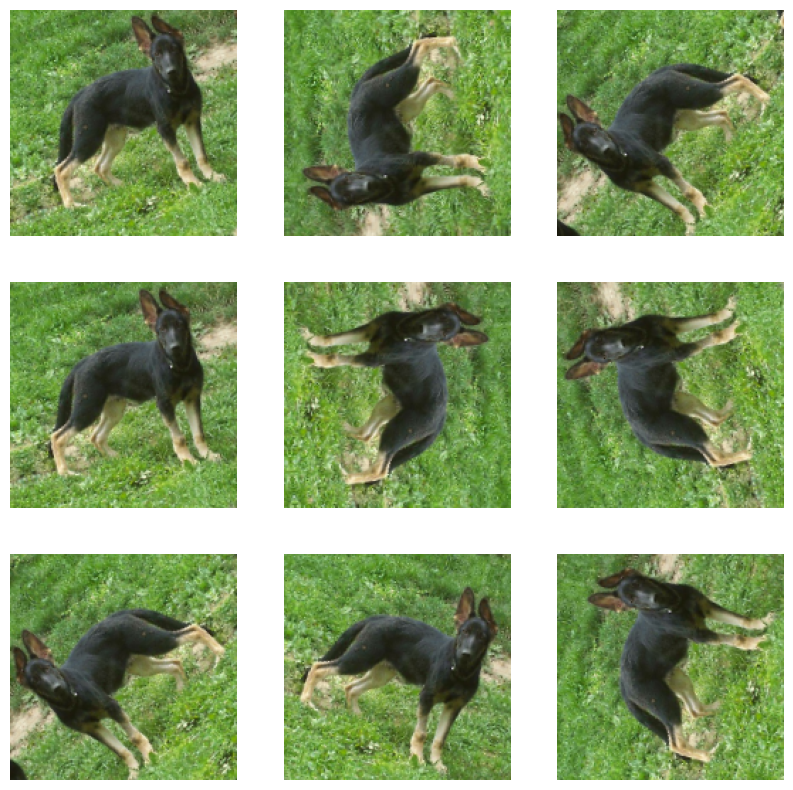

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    
    plt.axis('off')

In [13]:
preprocess_input=tf.keras.applications.mobilenet_v2.preprocess_input
rescale=tf.keras.layers.Rescaling(1.0/255,)


In [14]:
img_shape=IMG_SIZE+(3,)
base_Model=tf.keras.applications.MobileNetV2(input_shape=img_shape,include_top=False,weights='imagenet')
base_Model.trainable=False
base_Model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [15]:
image_batch,label_batch=next(iter(train_dataset))
feature_batch=base_Model(image_batch)

In [16]:
globalavg=tf.keras.layers.GlobalAveragePooling2D()
globalbatchavg=globalavg(feature_batch)


In [17]:
predeiction_layer=tf.keras.layers.Dense(1)
prediction_batch=predeiction_layer(globalbatchavg)

In [18]:
input=tf.keras.Input(shape=(160,160,3))
x=data_augmentation(input)
x=preprocess_input(x)
x=base_Model(x,training=False)
x=globalavg(x)
x=tf.keras.layers.Dropout(0.2)(x)
outputs=predeiction_layer(x)
model=tf.keras.Model(input,outputs)

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=['accuracy'])

train_History=model.fit(train_dataset,epochs=10,validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 25s 362ms/step - loss: 0.3498 - accuracy: 0.8330 - val_loss: 0.1128 - val_accuracy: 0.9567
Epoch 2/10
63/63 [==============================] - 22s 351ms/step - loss: 0.2074 - accuracy: 0.9160 - val_loss: 0.0869 - val_accuracy: 0.9703
Epoch 3/10
63/63 [==============================] - 22s 342ms/step - loss: 0.1903 - accuracy: 0.9175 - val_loss: 0.0716 - val_accuracy: 0.9740
Epoch 4/10
63/63 [==============================] - 22s 343ms/step - loss: 0.1709 - accuracy: 0.9325 - val_loss: 0.0659 - val_accuracy: 0.9740
Epoch 5/10
63/63 [==============================] - 22s 343ms/step - loss: 0.1678 - accuracy: 0.9325 - val_loss: 0.0586 - val_accuracy: 0.9777
Epoch 6/10
63/63 [==============================] - 21s 337ms/step - loss: 0.1437 - accuracy: 0.9380 - val_loss: 0.0610 - val_accuracy: 0.9752
Epoch 7/10
63/63 [==============================] - 21s 337ms/step - loss: 0.1614 - accuracy: 0.9340 - val_loss: 0.0516 - val_accuracy: 0.9839

In [25]:
import glob
for image_path in glob.glob("cats\*.jpg"):
    img = tf.keras.utils.load_img(
        image_path, target_size=(160, 160)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image {} most likely belongs to {} with a {:.2f} percent confidence."
        .format(image_path, class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 27ms/step
This image cats\cat.2000.jpg most likely belongs to cats with a 100.00 percent confidence.
1/1 [==============================] - 0s 33ms/step
This image cats\cat.2001.jpg most likely belongs to cats with a 100.00 percent confidence.
1/1 [==============================] - 0s 31ms/step
This image cats\cat.2002.jpg most likely belongs to cats with a 100.00 percent confidence.
1/1 [==============================] - 0s 26ms/step
This image cats\cat.2003.jpg most likely belongs to cats with a 100.00 percent confidence.
1/1 [==============================] - 0s 29ms/step
This image cats\cat.2004.jpg most likely belongs to cats with a 100.00 percent confidence.
1/1 [==============================] - 0s 28ms/step
This image cats\cat.2005.jpg most likely belongs to cats with a 100.00 percent confidence.
1/1 [==============================] - 0s 24ms/step
This image cats\cat.2006.jpg most likely belongs to cats with a 100.00 percent confidence.

1/1 [==============================] - 0s 25ms/step
This image cat.2479.jpg most likely belongs to cats with a 100.00 percent confidence.


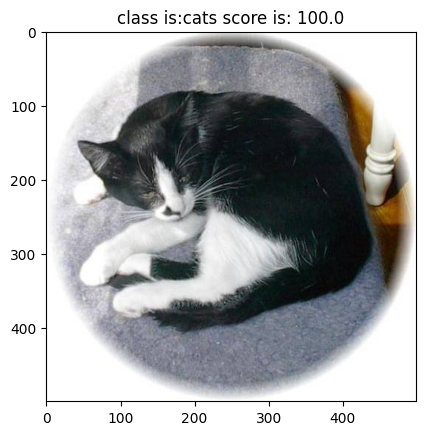

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg






image_path = "cat.2479.jpg"
img = tf.keras.utils.load_img(
    image_path, target_size=(160, 160)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
img = mpimg.imread('cat.2479.jpg')
imgplot = plt.imshow(img)


print("This image {} most likely belongs to {} with a {:.2f} percent confidence."
    .format(image_path, class_names[np.argmax(score)], 100 * np.max(score)))

plt.title("class is:" + class_names[np.argmax(score)]+" score is: "+ str(100 * np.max(score)))

plt.show()